#  Описание проекта
 
**Заголовок** 

 - Проект: Обучение с учителем: качество модели
 
**Описание проекта**

- Заказчик: Интернет-магазин «В один клик»
- Цель анализа: разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
- Образ результата:
    1. ML-модель, которая: 
        - предсказывает вероятность снижения покупательской активности клиента в следующие три месяца
        - учитывает данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
    2. Сегментация покупателей и персонализаяция предложений.
- Входные данные:
    - market_file.csv - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
    - market_money.csv - данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
    - market_time.csv - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
    - money.csv - данные о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Ход исследования**
    
- Шаг 1. Загрузка данных
- Шаг 2. Предобработка данных
- Шаг 3. Исследовательский анализ данных
- Шаг 4. Объединение таблиц
- Шаг 5. Корреляционный анализ
- Шаг 6. Использование пайплайнов
- Шаг 7. Анализ важности признаков
- Шаг 8. Сегментация покупателей
- Шаг 9. Общий вывод

**Рекомендация для заказчика**

- Заказчику внеобходимо начать контролировать маркеры/флаги, которые свидетельсвуют о снижении актвиности такие как: 
    - менее 11 минут  проведённого на сайте ( в т.ч. в категории мелкая бытовая техника и товары для детей),
    - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев > 0.2
    - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев менее 4
- Заказчику необходимо начать делать индивидуальные спец акции, когда маркеры свидетельсвуют о снижении актавности

## Шаг 1. Загрузка данных

In [1]:
#импорт базовых библиотек
import pandas as pd
import numpy as np
import seaborn as sns # для графика seaborn
!pip install phik
import phik
from phik.report import plot_correlation_matrix # для графика корреляции
import matplotlib.pyplot as plt # для графиков
import numpy as np 

from sklearn.model_selection import train_test_split # для разделения данных
from sklearn.model_selection import cross_val_score # для кросс-валидации

# класс pipeline
from sklearn.pipeline import Pipeline 

# классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# класс для работы с пропусками
from sklearn.impute import SimpleImputer

# функция для работы с метриками
from sklearn.metrics import roc_auc_score , recall_score , precision_score ,  f1_score , accuracy_score

# класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 

#SHAP
!pip install shap
import shap
from sklearn.inspection import permutation_importance



!pip install -U scikit-learn 

In [2]:
#открытие данных
try:
    market_file = pd.read_csv('/datasets/market_file.csv')  
except:
    market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    
try:
    market_money = pd.read_csv('/datasets/market_money.csv')     
except:
    market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')      

try:
    market_time = pd.read_csv('/datasets/market_time.csv')   
except:
    market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')    

try:
    money = pd.read_csv('/datasets/money.csv', sep=';')    
except:
    money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')     

In [3]:
# вывод пяти случайных строк
market_file.sample(5) 

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
614,215962,Прежний уровень,премиум,да,5.2,4,899,0.23,Товары для детей,2,4,8,12
428,215776,Прежний уровень,стандарт,нет,4.4,4,467,0.15,Техника для красоты и здоровья,2,2,2,10
138,215486,Снизилась,премиум,да,3.5,4,1021,0.35,Косметика и аксесуары,2,4,3,5
566,215914,Снизилась,стандарт,да,3.6,4,641,0.24,Домашний текстиль,4,5,5,15
27,215375,Снизилась,премиум,да,3.0,4,558,0.89,Товары для детей,3,3,7,4


In [4]:
# вывод пяти случайных строк
market_money.sample(5)

,id,Период,Выручка
421,215488,предыдущий_месяц,5612.0
1283,215775,препредыдущий_месяц,4934.0
1698,215914,препредыдущий_месяц,5416.0
2580,216208,препредыдущий_месяц,5397.0
1720,215921,препредыдущий_месяц,5208.0


In [5]:
# вывод пяти случайных строк
market_time.sample(5) 

,id,Период,минут
924,215810,предыдцщий_месяц,16
1055,215875,предыдцщий_месяц,9
1194,215945,текущий_месяц,23
2504,216600,предыдцщий_месяц,17
380,215538,текущий_месяц,4


In [6]:
# вывод пяти случайных строк
money.sample(5)

,id,Прибыль
893,216241,"3,91"
523,215871,"4,09"
1171,216519,"3,21"
858,216206,"4,14"
576,215924,"3,16"


In [7]:
#размер таблиц
         
print(f'Размер таблицы market_file: {market_file.shape}')  
print(f'Размер таблицы market_money: {market_money.shape}')  
print(f'Размер таблицы market_time: {market_time.shape}')  
print(f'Размер таблицы money: {money.shape}')  

Размер таблицы market_file: (1300, 13)
Размер таблицы market_money: (3900, 3)
Размер таблицы market_time: (2600, 3)
Размер таблицы money: (1300, 2)


In [8]:
#наименование колонок
market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

In [9]:
# изменение названий столбцов 
market_file = market_file.rename(columns= {'Покупательская активность':'покупательская_активность'
                                         , 'Тип сервиса':'тип_сервиса'
                                         , 'Разрешить сообщать':'разрешить_сообщать'
                                         , 'Маркет_актив_6_мес':'маркет_актив_6_мес'
                                         , 'Маркет_актив_тек_мес':'маркет_актив_тек_мес'
                                         , 'Длительность':'длительность'
                                         , 'Акционные_покупки':'акционные_покупки'
                                         , 'Популярная_категория':'популярная_категория'
                                         , 'Средний_просмотр_категорий_за_визит':'средний_просмотр_категорий_за_визит'
                                         , 'Неоплаченные_продукты_штук_квартал':'неоплаченные_продукты_штук_квартал'
                                         , 'Ошибка_сервиса':'ошибка_сервиса'
                                         , 'Страниц_за_визит':'страниц_за_визит'                                                                                 
                                        })

In [10]:
#наименование колонок
market_file.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

In [11]:
#наименование колонок
market_money.columns

Index(['id', 'Период', 'Выручка'], dtype='object')

In [12]:
# изменение названий столбцов 
market_money = market_money.rename(columns= {'Период':'период_выручки'
                                         , 'Выручка':'выручка'                                                                                
                                        })

In [13]:
#наименование колонок
market_money.columns

Index(['id', 'период_выручки', 'выручка'], dtype='object')

In [14]:
#наименование колонок
market_time.columns

Index(['id', 'Период', 'минут'], dtype='object')

In [15]:
# изменение названий столбцов 
market_time = market_time.rename(columns= {'Период':'период_времени'                                                                              
                                        })

In [16]:
#наименование колонок
market_time.columns

Index(['id', 'период_времени', 'минут'], dtype='object')

In [17]:
#наименование колонок
money.columns

Index(['id', 'Прибыль'], dtype='object')

In [18]:
# изменение названий столбцов 
money = money.rename(columns= {'Прибыль':'прибыль'                                                                              
                             })

In [19]:
#наименование колонок
money.columns

Index(['id', 'прибыль'], dtype='object')

 **Выводы**
 
- 4 таблицы market_file, market_money, market_time, money были пролиты
- изменение названий столбцов произведено во всех таблицах на змеинный регистр и пропислные буквы, оставлена кириллица 
- объединение таблиц будет произведено на шаге 4. Объединение таблиц

## Шаг 2. Предобработка данных

In [20]:
#основная информация о датафрейме
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [21]:
#основная информация о датафрейме
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3900 non-null   int64  
 1   период_выручки  3900 non-null   object 
 2   выручка         3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [22]:
#основная информация о датафрейме
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2600 non-null   int64 
 1   период_времени  2600 non-null   object
 2   минут           2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [23]:
#основная информация о датафрейме
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [24]:
#уникальные значения
market_money['период_выручки'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [25]:
#уникальные значения
market_time['период_времени'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [26]:
# замена написания 'предыдцщий_месяц' на 'предыдущий_месяц'
market_time['период_времени']= market_time['период_времени'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

In [27]:
#уникальные значения
market_time['период_времени'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [28]:
#уникальные значения
market_file['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [29]:
# замена написания 'предыдцщий_месяц' на 'предыдущий_месяц'
market_file['тип_сервиса']= market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')

In [30]:
#уникальные значения
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [31]:
# типы данных 
market_file.dtypes

id                                       int64
покупательская_активность               object
тип_сервиса                             object
разрешить_сообщать                      object
маркет_актив_6_мес                     float64
маркет_актив_тек_мес                     int64
длительность                             int64
акционные_покупки                      float64
популярная_категория                    object
средний_просмотр_категорий_за_визит      int64
неоплаченные_продукты_штук_квартал       int64
ошибка_сервиса                           int64
страниц_за_визит                         int64
dtype: object

In [32]:
# замена типа данных  int  на object
market_file['id']=market_file['id'].astype('object')

In [33]:
# типы данных 
market_file.dtypes

id                                      object
покупательская_активность               object
тип_сервиса                             object
разрешить_сообщать                      object
маркет_актив_6_мес                     float64
маркет_актив_тек_мес                     int64
длительность                             int64
акционные_покупки                      float64
популярная_категория                    object
средний_просмотр_категорий_за_визит      int64
неоплаченные_продукты_штук_квартал       int64
ошибка_сервиса                           int64
страниц_за_визит                         int64
dtype: object

In [34]:
# типы данных 
market_money.dtypes

id                  int64
период_выручки     object
выручка           float64
dtype: object

In [35]:
# замена типа данных  int  на object
market_money['id']=market_money['id'].astype('object')

In [36]:
# типы данных 
market_money.dtypes

id                 object
период_выручки     object
выручка           float64
dtype: object

In [37]:
# типы данных 
market_time.dtypes

id                 int64
период_времени    object
минут              int64
dtype: object

In [38]:
# замена типа данных  int  на object
market_time['id']=market_time['id'].astype('object')

In [39]:
# типы данных 
market_time.dtypes

id                object
период_времени    object
минут              int64
dtype: object

In [40]:
# типы данных 
money.dtypes

id          int64
прибыль    object
dtype: object

In [41]:
# замена типа данных  int  на object
money['id']=money['id'].astype('object')

In [42]:
# замена типа данных int на float
money['прибыль']= pd.to_numeric(
    money['прибыль'].str.replace(',', '.'),  
    errors='coerce'  
)

In [43]:
# типы данных 
money.dtypes

id          object
прибыль    float64
dtype: object

In [44]:
# количество пропущенных значений для каждого столбца 
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [45]:
# количество пропущенных значений для каждого столбца 
market_money.isna().sum()

id                0
период_выручки    0
выручка           0
dtype: int64

In [46]:
# количество пропущенных значений для каждого столбца 
market_time.isna().sum()

id                0
период_времени    0
минут             0
dtype: int64

In [47]:
# количество пропущенных значений для каждого столбца 
money.isna().sum()

id         0
прибыль    0
dtype: int64

In [48]:
# количество строк-дубликатов в данных (должно быть ноль)
market_file.duplicated().sum()

0

In [49]:
# количество строк-дубликатов в данных (должно быть ноль)
market_money.duplicated().sum()

0

In [50]:
# количество строк-дубликатов в данных (должно быть ноль)
market_time.duplicated().sum()

0

In [51]:
# количество строк-дубликатов в данных (должно быть ноль)
money.duplicated().sum()

0

 **Выводы**

Данные были предобработаны:
- названия в данных исправлены:
    - колонка период в market_time имела орфографические ошибки 
    - колонка тип сервиса в  market_file имела орфографические ошибки 
- типы даных заменены:
    - колонки id: типы данных заменены c тип "int" на тип "object"
    - колонка прибыль:типы данных заменены c тип "object" на тип "float"
- нет пропущенных значений для каждого столбца в каждой таблице
- нет строк-дубликатов в данных в каждой таблице

## Шаг 3. Исследовательский анализ данных

In [52]:
#разброс значений
pd.set_option('display.max_columns', None)
market_file.describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [53]:
#разброс значений
pd.set_option('display.max_columns', None)
market_money.describe()

,выручка
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000


In [54]:
#разброс значений
pd.set_option('display.max_columns', None)
market_time.describe()

,минут
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000


In [55]:
#разброс значений
pd.set_option('display.max_columns', None)
money.describe()

,прибыль
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000


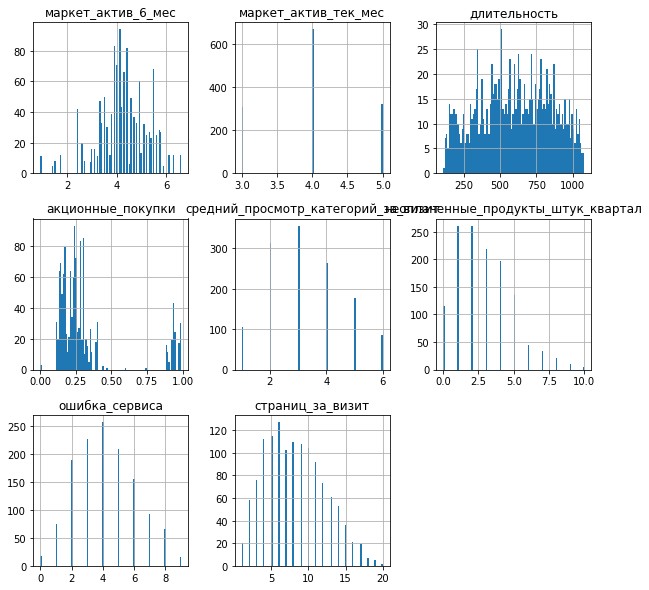

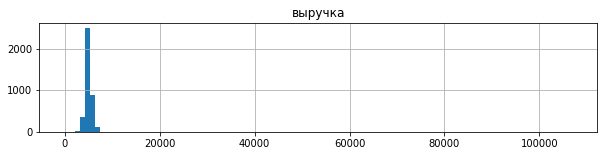

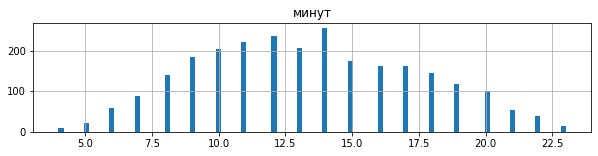

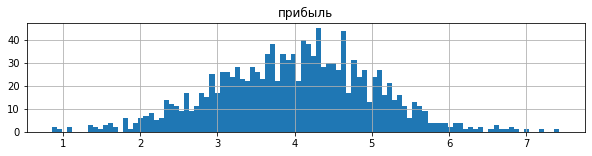

In [56]:
#построение гистограмм

market_file.hist(figsize=(10, 10)
        , bins = 100
       );

market_money.hist(figsize=(10, 2)
        , bins = 100
       );

market_time.hist(figsize=(10, 2)
        , bins = 100
       );

money.hist(figsize=(10, 2)
        , bins = 100
       );

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


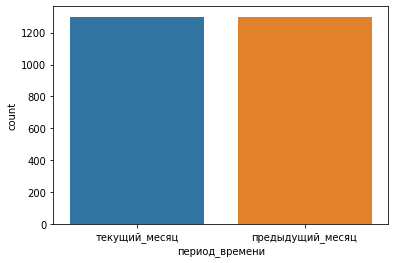

In [57]:
#countplot
sns.countplot(market_time['период_времени']
             );

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


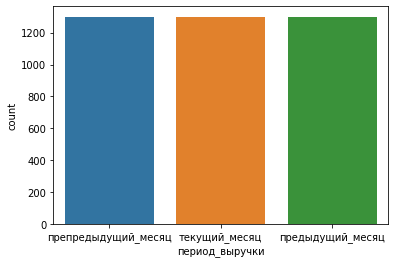

In [58]:
#countplot
sns.countplot(market_money['период_выручки']
             );

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


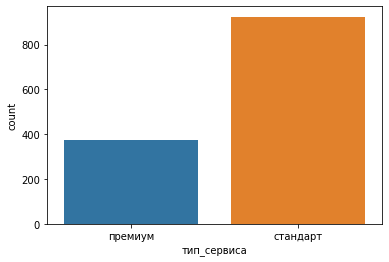

In [59]:
#countplot
sns.countplot(market_file['тип_сервиса']
             );

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


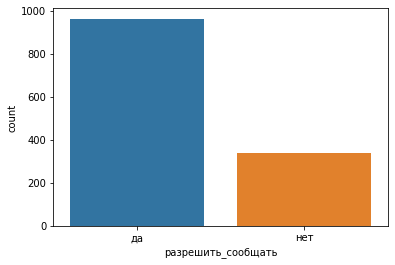

In [60]:
#countplot
sns.countplot(market_file['разрешить_сообщать']
             );

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


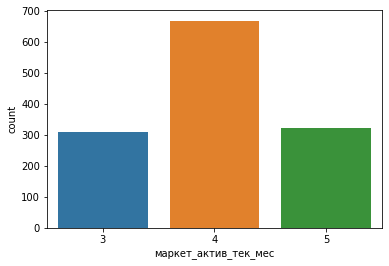

In [61]:
#countplot
sns.countplot(market_file['маркет_актив_тек_мес']
             );

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


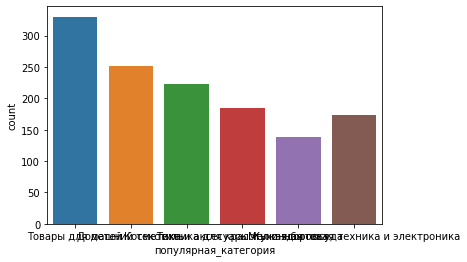

In [62]:
#countplot
sns.countplot(market_file['популярная_категория']
             );

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


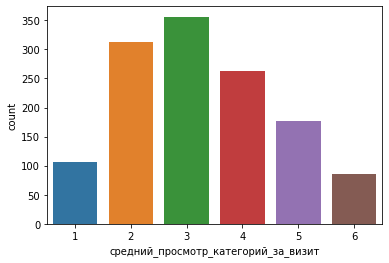

In [63]:
#countplot
sns.countplot(market_file['средний_просмотр_категорий_за_визит']
             );

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


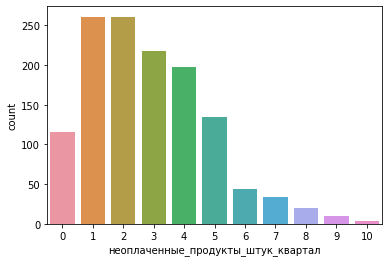

In [64]:
#countplot
sns.countplot(market_file['неоплаченные_продукты_штук_квартал']
             );

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


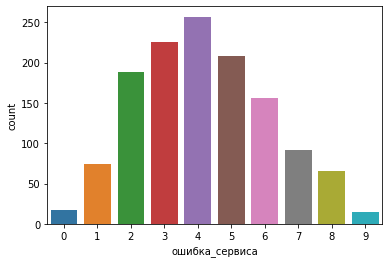

In [65]:
#countplot
sns.countplot(market_file['ошибка_сервиса']
             );

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


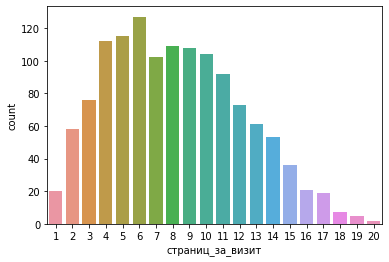

In [66]:
#countplot
sns.countplot(market_file['страниц_за_визит']
             );


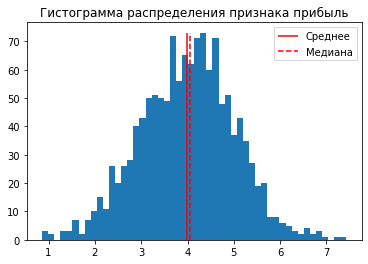

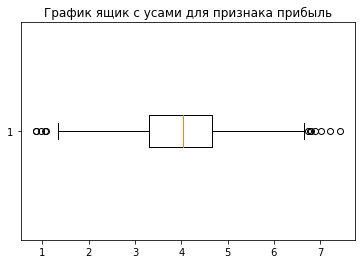

In [67]:
## визуализация распределения признака
# частотная гистограмма распределения признака с bins=50
bins = plt.hist(money['прибыль'], bins=50)
plt.vlines(x=money['прибыль'].mean(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
plt.vlines(x=money['прибыль'].median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')
plt.title('Гистограмма распределения признака прибыль')
plt.legend()
plt.show()

# ящик с усами с горизонтальной ориентацией
plt.title('График ящик с усами для признака прибыль')
plt.boxplot(money['прибыль'], vert=False)
plt.show()


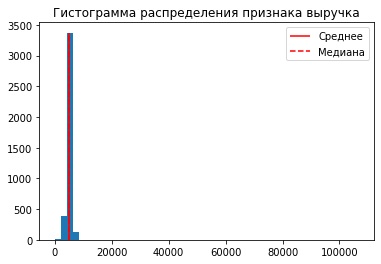

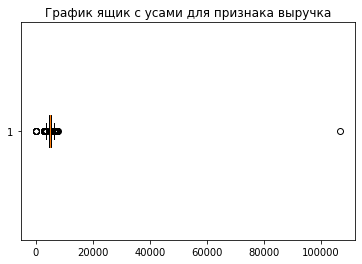

In [68]:
## визуализация распределения признака
# частотная гистограмма распределения  признака с bins=50
bins = plt.hist(market_money['выручка'], bins=50)
plt.vlines(x=market_money['выручка'].mean(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), label='Среднее')
plt.vlines(x=market_money['выручка'].median(), colors='red', ymin=bins[0].min(), ymax=bins[0].max(), linestyles='--', label='Медиана')
plt.title('Гистограмма распределения признака выручка')
plt.legend()
plt.show()

# ящик с усами с горизонтальной ориентацией
plt.title('График ящик с усами для признака выручка')
plt.boxplot(market_money['выручка'], vert=False)
plt.show()

In [69]:
#описание переменной 
market_money['выручка'].describe()

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

In [70]:
#анализ выброса у id 215380
market_money.query('выручка > 10000')

,id,период_выручки,выручка
98,215380,текущий_месяц,106862.2


In [71]:
#описание переменной 
market_money.query('id == 215380')

,id,период_выручки,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


In [72]:
money.query('id == 215380')

,id,прибыль
32,215380,3.88


In [73]:
#клиента id = 215380 исключаем из всех данных.
market_money = market_money.query('id != 215380')
market_file = market_file.query('id != 215380')
market_time = market_time.query('id != 215380')
money = money.query('id != 215380')

In [74]:
# анализ 
pd.set_option('display.max_rows',None)

In [75]:
# анализ значений данных по покупкам в разные периоды по клиентно 
pd.set_option('display.max_rows',None)
pivot_period=market_money.pivot_table(index='id', columns='период_выручки', values='выручка', aggfunc='sum')
pivot_period.columns=['one_month_before_rev','two_months_before_rev','current_month_rev']
pivot_period['cum_3_months_rev']=pivot_period['one_month_before_rev']+pivot_period['two_months_before_rev']+pivot_period['current_month_rev']
pivot_period.sort_values(by='cum_3_months_rev',ascending=True)

,one_month_before_rev,two_months_before_rev,current_month_rev,cum_3_months_rev
id,,,,
215348,0.0,0.0,3293.1,3293.1
215359,0.0,0.0,4735.0,4735.0
215357,0.0,0.0,5986.3,5986.3
215564,2890.0,4213.0,3334.6,10437.6
215716,3067.0,4165.0,3343.9,10575.9
215388,3188.0,4182.0,3232.2,10602.2
215466,3202.0,4748.0,2758.7,10708.7
215478,2960.0,4682.0,3078.3,10720.3
215453,3332.0,4290.0,3143.5,10765.5


In [76]:
# анализ количества значений в таблицах
print(f'Размер таблицы market_money: {market_money.shape}')
print(f'Размер таблицы pivot_period: {pivot_period.shape}') 
print('----------------------------------------------------------------------------')
unique_id_market_money = len(market_money['id'].unique())
zero_3mcum_rev = len(pivot_period.query('cum_3_months_rev ==0'))
zero_current_month_rev = len(pivot_period.query('current_month_rev ==0'))
zero_one_month_before_rev = len(pivot_period.query('one_month_before_rev ==0'))
zero_two_months_before_rev = len(pivot_period.query('two_months_before_rev ==0'))

print(f'Количество уникальных клиентов в market_money: {unique_id_market_money}')
print(f'Количество клиентов c нулевыми доходами за 3 месяца кумулятивно в market_money: {zero_3mcum_rev}')
print(f'Количество клиентов c нулевыми доходами за текущий месяц в market_money: {zero_current_month_rev}')
print(f'Количество клиентов c нулевыми доходами за прошлый месяц в market_money: {zero_one_month_before_rev}')
print(f'Количество клиентов c нулевыми доходами за позапрошлый месяц в market_money: {zero_two_months_before_rev}')


Размер таблицы market_money: (3897, 3)
Размер таблицы pivot_period: (1299, 4)
----------------------------------------------------------------------------
Количество уникальных клиентов в market_money: 1299
Количество клиентов c нулевыми доходами за 3 месяца кумулятивно в market_money: 0
Количество клиентов c нулевыми доходами за текущий месяц в market_money: 0
Количество клиентов c нулевыми доходами за прошлый месяц в market_money: 3
Количество клиентов c нулевыми доходами за позапрошлый месяц в market_money: 3


In [77]:
# анализ id c нулевыми доходами за прошлый месяц в market_money
pivot_period.query('one_month_before_rev ==0')

,one_month_before_rev,two_months_before_rev,current_month_rev,cum_3_months_rev
id,,,,
215348,0.0,0.0,3293.1,3293.1
215357,0.0,0.0,5986.3,5986.3
215359,0.0,0.0,4735.0,4735.0


**Комментарий**

Три клиента c нулевыми доходами за прошлый И позапрошлый месяц - одни и теже люди c id 215348, 215357, 215359

In [78]:
#анализ прибыли 
money.sort_values(by='прибыль',ascending=True).head()

,id,прибыль
774,216122,0.86
976,216324,0.86
0,215348,0.98
182,215530,1.06
938,216286,1.08


**Комментарий**

Три клиента принесли  менее 1 у.е.среднемесячной прибыли за последние 3 месяца

        id	прибыль
    216122	0.86
    216324	0.86
    215348	0.98

In [79]:
# анализ значений данных по минутам в разные периоды агрегировано - market_time
pd.set_option('display.max_rows',None)
pivot_min_agg=market_time.pivot_table(index='период_времени', values='минут', aggfunc='sum')
pivot_min_agg

,минут
период_времени,
предыдущий_месяц,17496
текущий_месяц,17152


**Комментарий**

суммарно кол-во времени всех клиентов, проведённого на сайте, в минутах упало

In [80]:
# анализ значений данных по клиентам в разные периоды агрегировано - market_time
pd.set_option('display.max_rows',None)
pivot_min_agg_cl=market_time.pivot_table(index='период_времени', values='id', aggfunc='count')
pivot_min_agg_cl

,id
период_времени,
предыдущий_месяц,1299
текущий_месяц,1299


**Комментарий**

кол-во клиентов одинаково в каждый период в market_time => в среднем кол-во времени упало

In [81]:
# анализ значений данных по минутам в разные периоды по клиентно - market_time
pd.set_option('display.max_rows',None)
pivot_min=market_time.pivot_table(index='id', columns='период_времени', values='минут', aggfunc='sum')
pivot_min.columns=['one_month_before_min','current_month_min']
pivot_min['increase_percent_min']=pivot_min['current_month_min']/pivot_min['one_month_before_min']-1
pivot_min.sort_values(by='increase_percent_min',ascending=True)


,one_month_before_min,current_month_min,increase_percent_min
id,,,
216355,20,5,-0.750000
216443,21,6,-0.714286
215808,17,5,-0.705882
215858,20,6,-0.700000
216633,20,6,-0.700000
216381,13,4,-0.692308
216007,12,4,-0.666667
215764,15,5,-0.666667
215883,18,6,-0.666667


In [82]:
# анализ количества значений в таблицах
print(f'Размер таблицы market_time: {market_time.shape}')
print(f'Размер таблицы pivot_min: {pivot_min.shape}') 
print('----------------------------------------------------------------------------')
unique_id_market_time = len(market_time['id'].unique())
zero_increase_time = len(pivot_min.query('increase_percent_min == 0'))
positive_increase_time = len(pivot_min.query('increase_percent_min > 0'))
negative_increase_time = len(pivot_min.query('increase_percent_min < 0'))


print(f'Количество уникальных клиентов в market_time: {unique_id_market_time}')
print(f'Количество клиентов c нулевым ростом времени, проведённого на сайте в market_time: {zero_increase_time}')
print(f'Количество клиентов c положительным ростом времени, проведённого на сайте в market_time: {positive_increase_time}')
print(f'Количество клиентов c отрицательным ростом времени, проведённого на сайте в market_time: {negative_increase_time}')


Размер таблицы market_time: (2598, 3)
Размер таблицы pivot_min: (1299, 3)
----------------------------------------------------------------------------
Количество уникальных клиентов в market_time: 1299
Количество клиентов c нулевым ростом времени, проведённого на сайте в market_time: 116
Количество клиентов c положительным ростом времени, проведённого на сайте в market_time: 583
Количество клиентов c отрицательным ростом времени, проведённого на сайте в market_time: 600


In [83]:
# анализ значений данных по минутам в разные периоды по клиентно - market_time
pd.set_option('display.max_rows',None)
pivot_file=market_file.pivot_table(index=['популярная_категория','тип_сервиса' ]
                                   ,columns='покупательская_активность'
                                  , values='id'
                                  , aggfunc='count')
pivot_file

покупательская_активность                         Прежний уровень  Снизилась
популярная_категория                 тип_сервиса                            
Домашний текстиль                    премиум                   44         29
                                     стандарт                 105         73
Косметика и аксесуары                премиум                   32         47
                                     стандарт                  86         58
Кухонная посуда                      премиум                   20         22
                                     стандарт                  52         44
Мелкая бытовая техника и электроника премиум                   37         10
                                     стандарт                 110         17
Техника для красоты и здоровья       премиум                   26         16
                                     стандарт                 106         35
Товары для детей                     премиум                   47         45
                                     стандарт                 137        101

**Комментарий**

Cамая популярная категория - Товары для детей - стандарт.
Для большего кол-ва клиентов она и снизилась.

In [84]:
#покупательская_активность делаю как значения -1 и 0 для лучшей интерпретируемости в будущем 
#  группировка по прибыльности покупателей

#лучше начать с кодирования "снизилась" единицей (судя по постановке задачи именно "снизилась" наш положительный класс),
#"осталось" - нулем, это можно сделать вручную или с помощью LabelEncoder

def categorize_act(act):
    if act == 'Прежний уровень' :
        return 0
    else:
        return 1

market_file['act_type'] = market_file.apply(lambda x: categorize_act(x['покупательская_активность']), axis=1)
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,act_type
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,1
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,1
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,1
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,1
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,1


 **Выводы**

- Все клиенты (1300) имеют покупательскую  активностью не менее трёх месяцев, то есть  все покупали минимум 1 товар за последние 3 месяца, при этом:
    - Количество клиентов c нулевыми доходами за 3 месяца кумулятивно в market_money: 0
    - Количество клиентов c нулевыми доходами за текущий месяц в market_money: 0
    - Количество клиентов c нулевыми доходами за прошлый месяц в market_money: 3
    - Количество клиентов c нулевыми доходами за позапрошлый месяц в market_money: 3
    - Три клиента c нулевыми доходами за прошлый И позапрошлый месяц - одни и теже люди c id 215348, 215357, 215359	
- Три клиента принесли  менее 1 у.е.среднемесячной прибыли за последние 3 месяца: 216122, 216324, 215348
- Суммарное падение времени, проведённого на сайте, по всем клиентам в market_time при одинаковом кол-ве клиентов (1300) в прошлый и текущий месяца:
    - Количество клиентов c нулевым ростом времени, проведённого на сайте в market_time: 116
    - Количество клиентов c положительным ростом времени, проведённого на сайте в market_time: 584
    - Количество клиентов c отрицательным ростом времени, проведённого на сайте в market_time: 600
    
- Cамая популярная категория - Товары для детей - стандарт. Для большего кол-ва клиентов она и снизилась.
- Покупательская_активность делаю как значения 1 (снизилась) и 0 (прежняя) для лучшей интерпретируемости в будущем 

новые комментарии после проверки 1
- Графики распредения и ящики с усами построены
- У выручки есть выброс, скорее всего данные были некооертно заведены. Коректность данных по выручке надо перепроверить.
- Так как мы не значем натоящий это выброс или ошибка, то клиента id = 215380 исключаем из всех данных. /

In [85]:
# анализ значений данных по покупкам в разные периоды по клиентно 
##не проявили активность хотя бы в одном из 3 месяцев

#  группировка по отсутсвтии активности в one_month_before
def categorize_ottok(ottok):
    if ottok <=0 :
        return 1
    else:
        return 0
 

pivot_period['ottok_1'] = pivot_period.apply(lambda x: categorize_ottok(x['one_month_before_rev']), axis=1)    
pivot_period['ottok_2'] = pivot_period.apply(lambda x: categorize_ottok(x['two_months_before_rev']), axis=1)
pivot_period['ottok_0'] = pivot_period.apply(lambda x: categorize_ottok(x['current_month_rev']), axis=1)
pivot_period['ottok_cum'] = pivot_period['ottok_1']+pivot_period['ottok_2']+pivot_period['ottok_0']
pivot_period.query('ottok_cum>0')

,one_month_before_rev,two_months_before_rev,current_month_rev,cum_3_months_rev,ottok_1,ottok_2,ottok_0,ottok_cum
id,,,,,,,,
215348,0.0,0.0,3293.1,3293.1,1,1,0,2
215357,0.0,0.0,5986.3,5986.3,1,1,0,2
215359,0.0,0.0,4735.0,4735.0,1,1,0,2


## Шаг 4. Объединение таблиц

In [86]:
#объединение таблиц  market_file и market_money
data_market_file_money = pd.merge(market_file, market_money, on='id', how='left')
data_market_file_money.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,act_type,период_выручки,выручка
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,1,препредыдущий_месяц,0.0
1,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,1,текущий_месяц,3293.1
2,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,1,предыдущий_месяц,0.0
3,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,1,препредыдущий_месяц,4472.0
4,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,1,текущий_месяц,4971.6


In [87]:
#объединение таблиц  data_market_file_money и market_time
df_fin= pd.merge(data_market_file_money, market_time, on='id', how='left')
df_fin.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,act_type,период_выручки,выручка,период_времени,минут
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,1,препредыдущий_месяц,0.0,текущий_месяц,14
1,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,1,препредыдущий_месяц,0.0,предыдущий_месяц,13
2,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,1,текущий_месяц,3293.1,текущий_месяц,14
3,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,1,текущий_месяц,3293.1,предыдущий_месяц,13
4,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,1,предыдущий_месяц,0.0,текущий_месяц,14


 **Выводы**
 
- Объединены таблицы market_file.csv, market_money.csv, market_time.csv в df
- В df_fin есть 2 поля "период_выручки" из market_money  и "период времени" из market_time

новые комментарии после проверки N1 

- Ниже объединила все в один df - теперь каждая строка отвечает за конкретного уникального клиента.
- исключены 3 клиента ( id 215348, 215357, 215359),  котороые уже перешли в другую категорию (у них не снижается активность, а уже отсвутет в определенные месяцы), теперь всего 1296 клиентов (напомню, что 215380 был исключен ранее, так как его данные по выручке в тек. месяцу содержат выброс и информацию по нему коиент должен перепроверить )

In [88]:
#создание датафрейма из pivot_period  (который сделан на базе market_money) для объединения
market_money_for_merge = pivot_period
market_money_for_merge.head()

,one_month_before_rev,two_months_before_rev,current_month_rev,cum_3_months_rev,ottok_1,ottok_2,ottok_0,ottok_cum
id,,,,,,,,
215348,0.0,0.0,3293.1,3293.1,1,1,0,2
215349,5216.0,4472.0,4971.6,14659.6,0,0,0,0
215350,5457.5,4826.0,5058.4,15341.9,0,0,0,0
215351,6158.0,4793.0,6610.4,17561.4,0,0,0,0
215352,5807.5,4594.0,5872.5,16274.0,0,0,0,0


In [89]:
#объединение таблиц  market_file и market_money_for_merge
data_market_file_money_for_merge = pd.merge(market_file, market_money_for_merge, on='id', how='left')
data_market_file_money_for_merge.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1298
Data columns (total 22 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1299 non-null   object 
 1   покупательская_активность            1299 non-null   object 
 2   тип_сервиса                          1299 non-null   object 
 3   разрешить_сообщать                   1299 non-null   object 
 4   маркет_актив_6_мес                   1299 non-null   float64
 5   маркет_актив_тек_мес                 1299 non-null   int64  
 6   длительность                         1299 non-null   int64  
 7   акционные_покупки                    1299 non-null   float64
 8   популярная_категория                 1299 non-null   object 
 9   средний_просмотр_категорий_за_визит  1299 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 11  ошибка_сервиса                

In [90]:
#создание датафрейма из pivot_min  (который сделан на базе market_time) для объединения
market_time_for_merge = pivot_min[['one_month_before_min' , 'current_month_min']]
market_time_for_merge.head()

,one_month_before_min,current_month_min
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [91]:
#объединение таблиц  data_market_file_money и market_time
df= pd.merge(data_market_file_money_for_merge, market_time_for_merge, on='id', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1298
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1299 non-null   object 
 1   покупательская_активность            1299 non-null   object 
 2   тип_сервиса                          1299 non-null   object 
 3   разрешить_сообщать                   1299 non-null   object 
 4   маркет_актив_6_мес                   1299 non-null   float64
 5   маркет_актив_тек_мес                 1299 non-null   int64  
 6   длительность                         1299 non-null   int64  
 7   акционные_покупки                    1299 non-null   float64
 8   популярная_категория                 1299 non-null   object 
 9   средний_просмотр_категорий_за_визит  1299 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1299 non-null   int64  
 11  ошибка_сервиса                

In [92]:
# исключены клиенты,  которые не проявили активность хотя бы в одном из 3 месяцев

df = df.query('ottok_cum ==0')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1298
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   object 
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

In [93]:
# количество строк-дубликатов в данных (должно быть ноль)
df.duplicated().sum()

0

## Шаг 5. Корреляционный анализ

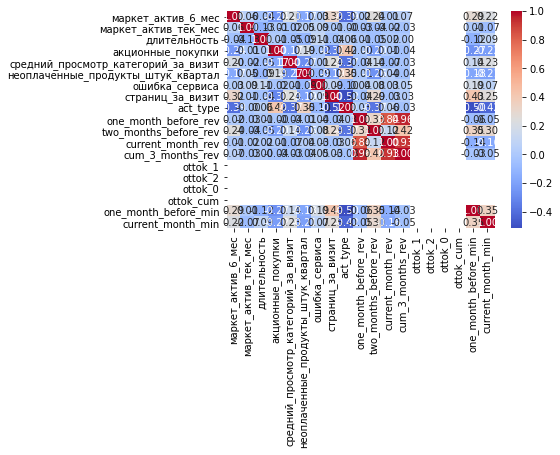

In [94]:
# корреляционный анализ количесвенных признаков по пирсону
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm');

 **Комментарий**
 
Теснота связи слабая или ниже между количесвенными параметрами (Корреляция по Пирсону): 
- Слабая "-" теснота связи акционные_покупки и страниц_за_визит 
- Слабая "+" теснота связи минут и страниц_за_визит 


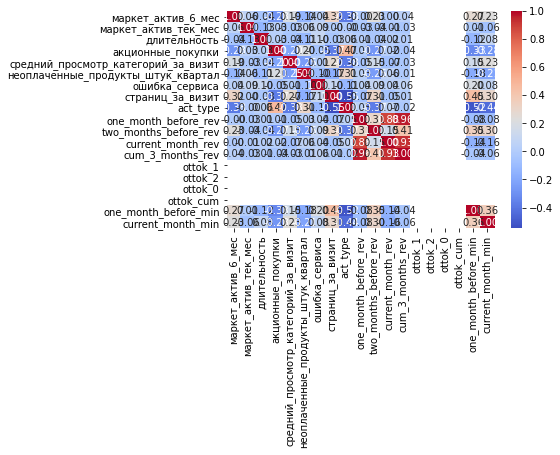

In [95]:
# корреляционный анализ количесвенных признаков по spearman
corr_spearman = df.corr(method='spearman')
sns.heatmap(corr_spearman, annot=True, fmt='.2f', cmap='coolwarm');

In [96]:
# корреляционный анализ количественных  и качественных признаков
df.phik_matrix()
#sns.heatmap(df.phik_matrix(), annot=True, fmt='.1f', cmap='cividis');

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'act_type', 'one_month_before_rev', 'two_months_before_rev', 'current_month_rev', 'cum_3_months_rev', 'ottok_1', 'ottok_2', 'ottok_0', 'ottok_cum', 'one_month_before_min', 'current_month_min']


/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable id is large: 1296. Are you sure this is not an interval variable? Analysis for pairs of variables including id can be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable ottok_1 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable ottok_2 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable ottok_0 for analysis 1. Dropping this column
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable ottok_cum for analysis 1. Dropping this column
  warnings.warn(


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,act_type,one_month_before_rev,two_months_before_rev,current_month_rev,cum_3_months_rev,one_month_before_min,current_month_min
id,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
покупательская_активность,1.0,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.999992,0.224638,0.497393,0.197213,0.160513,0.685138,0.576770
тип_сервиса,1.0,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.129940,0.000000,0.069704,0.124216,0.000000,0.131814,0.000000
разрешить_сообщать,1.0,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.000000,0.080842,0.000000,0.060907,0.000000,0.038387,0.000000
маркет_актив_6_мес,1.0,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,0.544831,0.155476,0.315331,0.039795,0.166217,0.363950,0.330601
маркет_актив_тек_мес,1.0,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.000000,0.051824,0.000000,0.000000,0.000000,0.107945,0.061410
длительность,1.0,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.099901,0.125572,0.113200,0.147048,0.146907,0.026448,0.101481
акционные_покупки,1.0,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.311418,0.506276,0.060733,0.226381,0.071094,0.014891,0.262324,0.250558
популярная_категория,1.0,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.160300,0.299717,0.252097,0.043528,0.237240,0.196846,0.195233,0.089883
средний_просмотр_категорий_за_визит,1.0,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.262271,0.539607,0.098440,0.176828,0.092597,0.000000,0.159837,0.182568


 **Комменатрий**
 
- Самые высокие корреляции между категориальными и количесвенными признаками (коэффициент корреляции Фи):
            покупательская_активность - маркет_актив_6_мес	0.6
            покупательская_активность - страниц_за_визит	0.8
                        покупательская_активность- минут	0.6
                        
- О мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. В такой ситуации лишние коррелирующие признаки нужно удалять из обучающей выборки.Среди количесвенных признаков таких нет => т.о, надо убрать поле ID 


 **Выводы**
 
- Теснота связи слабая или ниже между количесвенными параметрами (корреляция по Пирсону):

    - Слабая "-" теснота связи акционные_покупки и страниц_за_визит
    - Слабая "+" теснота связи минут и страниц_за_визит

- Весьма высокая теснота связи (корреляция по Спирмену)
       
    - cum_3_months_rev	- one_month_before_rev	1.0
    - current_month_rev	- one_month_before_rev	0.9

- Заметная теснота связи (корреляция по Спирмену)

    - страниц_за_визит	- act_type	-0.5
    - act_type	- акционные_покупки	0.5
    - one_month_before_min	- страниц_за_визит	0.5
    - one_month_before_min	- act_type	-0.5
  
- Самые высокие корреляции между категориальными и количесвенными признаками (коэффициент корреляции Фи):

    - покупательская_активность - маркет_актив_6_мес	0.6
    - покупательская_активность - страниц_за_визит	0.8
    -  покупательская_активность- минут	0.6
                        
- О мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. В такой ситуации лишние коррелирующие признаки нужно удалять из обучающей выборки.Среди количесвенных признаков таких нет 

=> т.о, надо убрать поле ID, cum_3_months_rev  из анализа. ottok (1,2,cum) тоже уберем , они уже не нуны, таких клиентов воттоке мы уже исключили 

## Шаг 6. Использование пайплайнов

In [102]:
# пайплайн, который выберет лучшую комбинацию модели и гиперпараметров. 
# использованы модели:
#DecisionTreeClassifier() с гиперпараметрами
#KNeighborsClassifier() с гиперпараметрами 
#LogisticRegression () с гиперпараметрами
#SVC () с гиперпараметрами
#Рассчет метрики ROC-AUC ovo на тренировочной и тестовой выборках.



#import numpy as np
#import pandas as pd
#from sklearn.model_selection import train_test_split

# загружаем класс pipeline
#from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
#from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
#from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
#from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
#from sklearn.metrics import roc_auc_score

# импортируем класс RandomizedSearchCV
#from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели
#from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.svm import SVC 


RANDOM_STATE = 42
TEST_SIZE = 0.25

# загружаем данные
df_1 = df

X_train, X_test, y_train, y_test = train_test_split(
    df_1.drop(['покупательская_активность', 'act_type','id', 'cum_3_months_rev'
               ,'ottok_1','ottok_2','ottok_0','ottok_cum'            
              ], axis=1),
    df_1['act_type'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_1['act_type'])

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['тип_сервиса'
                 , 'популярная_категория'
              ]

ord_columns = ['разрешить_сообщать'] 

num_columns = ['маркет_актив_6_мес'
                 , 'маркет_актив_тек_мес'
                 , 'длительность'
                 , 'акционные_покупки'
                 , 'средний_просмотр_категорий_за_визит'
                 , 'неоплаченные_продукты_штук_квартал'
                 , 'ошибка_сервиса'
                 , 'страниц_за_визит'
                 , 'one_month_before_rev'
                 , 'two_months_before_rev'
                 , 'current_month_rev'
                 , 'one_month_before_min'
                 , 'current_month_min'
              ]

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))  # , sparse=False - убираем (если библитоека новая !pip install -U scikit-learn )handle_unknown='error' - при появлении новых категорий в тестовых данных пайплайн упадёт с ошибкой.
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['да', 'нет']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
           )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 40),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()]
        ,'models__n_neighbors': range(2, 50)
        ,'models__weights': ['uniform', 'distance']       
#uniform – если все соседи примерно равноценны (например, данные нормализованы, и расстояния не сильно различаются).
#distance – если ближайшие объекты важнее дальних (например, в данных есть выбросы или шум).
        ,'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
              random_state=RANDOM_STATE
        )]
        ,'models__penalty': ['l2', 'elasticnet']  
#Для большинства задач L2 — безопасный выбор, но L1 незаменим, когда нужна простота модели и отбор признаков
# L1 - Обнуляет неважные признаки, нестабильна к Мультиколлинеарности
# L2 - Только уменьшает коэффициенты неважных признаков, стабильна к Мультиколлинеарности       
# ElasticNet (L1 + L2)  - Нужен баланс между отбором признаков (L1) и устойчивостью к корреляции (L2).
        
        ,'models__solver': ['saga'] # единственный общий solver для 'models__penalty': ['l2', 'elasticnet']       
        ,'models__C': range(1, 10)
        ,'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },

    # словарь для модели SVC() #'models__gamma': [0.1,1,10]        'models__C': [0.1,1,10,100] 
    {
        'models': [SVC(
            random_state=RANDOM_STATE
            , probability=True # Если probability=False, SVC не сможет вернуть вероятности, и вызов predict_proba() приведёт к ошибке
        )]
        ,'models__kernel': ['rbf','linear'] # исключены 'sigmoid','poly' для более быстрой отработки запроса
        ,'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }

]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='precision',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)


# проверьте работу модели на тестовой выборке
# Предсказания для тестовой выборки
y_test_pred_class = randomized_search.predict(X_test)
y_test_pred_proba = randomized_search.predict_proba(X_test)[:, 1]

# Вывод метрик
print(f'\nМетрики на тестовой выборке:')
print(f'ROC-AUC: {roc_auc_score(y_test, y_test_pred_proba):.4f}')
print(f'Precision: {precision_score(y_test, y_test_pred_class):.4f}')
print(f'Recall: {recall_score(y_test, y_test_pred_class):.4f}')
print(f'F1-score: {f1_score(y_test, y_test_pred_class):.4f}')
print(f'Accuracy: {accuracy_score(y_test, y_test_pred_class):.4f}')


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['тип_сервиса',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                            

 **Комментарий**
 
- Лучше всего справилась модель KNeighborsClassifier(n_neighbors=24, weights='distance') с StandardScaler
- Метрика лучшей модели на тренировочной выборке: 0.9334420605685685
- Метрики на тестовой выборке:
    - ROC-AUC: 0.9213
    - Precision: 0.9802
    - Recall: 0.8049
    - F1-score: 0.8839
    - Accuracy: 0.9198

In [103]:
#вывод всех результатов моделей в датафрейм
#pd.set_option('display.max_columns', None)

# все результаты кросс-валидации
results_df = pd.DataFrame(randomized_search.cv_results_)

# Выбор и сортировка нужных колонок
final_results = results_df[
    ['rank_test_score', 'param_models', 'mean_test_score', 'std_test_score', 'params']
].sort_values('rank_test_score')

# отображение
pd.set_option('display.max_colwidth', 200)
final_results

,rank_test_score,param_models,mean_test_score,std_test_score,params
4,1,KNeighborsClassifier(),0.933442,0.020328,"{'preprocessor__num': StandardScaler(), 'models__weights': 'uniform', 'models__n_neighbors': 24, 'models': KNeighborsClassifier()}"
3,2,KNeighborsClassifier(),0.931425,0.015746,"{'preprocessor__num': StandardScaler(), 'models__weights': 'distance', 'models__n_neighbors': 32, 'models': KNeighborsClassifier()}"
0,3,KNeighborsClassifier(),0.908706,0.053121,"{'preprocessor__num': MinMaxScaler(), 'models__weights': 'distance', 'models__n_neighbors': 37, 'models': KNeighborsClassifier()}"
9,4,DecisionTreeClassifier(random_state=42),0.837506,0.009786,"{'preprocessor__num': StandardScaler(), 'models__max_features': 7, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
5,5,DecisionTreeClassifier(random_state=42),0.786797,0.061447,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 2, 'models__max_depth': 7, 'models': DecisionTreeClassifier(random_state=42)}"
2,6,KNeighborsClassifier(),0.769285,0.081973,"{'preprocessor__num': 'passthrough', 'models__weights': 'uniform', 'models__n_neighbors': 38, 'models': KNeighborsClassifier()}"
6,7,DecisionTreeClassifier(random_state=42),0.755928,0.064372,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 5, 'models__max_depth': 21, 'models': DecisionTreeClassifier(random_state=42)}"
1,8,DecisionTreeClassifier(random_state=42),0.746410,0.056957,"{'preprocessor__num': 'passthrough', 'models__max_features': 8, 'models__max_depth': 37, 'models': DecisionTreeClassifier(random_state=42)}"
8,9,DecisionTreeClassifier(random_state=42),0.734949,0.057204,"{'preprocessor__num': StandardScaler(), 'models__max_features': 8, 'models__max_depth': 15, 'models': DecisionTreeClassifier(random_state=42)}"
7,10,LogisticRegression(random_state=42),0.641994,0.090825,"{'preprocessor__num': 'passthrough', 'models__solver': 'saga', 'models__penalty': 'l2', 'models__C': 7, 'models': LogisticRegression(random_state=42)}"


<div class="alert alert-info"> <b>Комментарии студентаV1:</b> 

добавлено

    
</div>

In [104]:
# randomized_search.cv_results_
results_df_2 = pd.DataFrame(randomized_search.cv_results_)

# Добавляем колонку с   моделями 
results_df_2['модель'] = results_df_2['param_models'].apply(lambda x: x.__class__.__name__)



detailed_names = {

    'mean_score_time': 'время_предсказания',
    'mean_test_score': 'метрика_на_кроссвалидации',
    'rank_test_score': 'место_по_метрике'
}

results_df_2_renamed = results_df_2.rename(columns=detailed_names)
best_models = (
    results_df_2_renamed
    .sort_values('место_по_метрике')
    .groupby('модель')
    .first()
    .reset_index()
)
# Выводим интересующие нас cтолбцы
best_models[['модель', 'время_предсказания', 'метрика_на_кроссвалидации', 'место_по_метрике']].sort_values('место_по_метрике')

,модель,время_предсказания,метрика_на_кроссвалидации,место_по_метрике
1,KNeighborsClassifier,0.012875,0.933442,1
0,DecisionTreeClassifier,0.010778,0.837506,4
2,LogisticRegression,0.013254,0.641994,10


**Комментари**

KNeighborsClassifier предсказывается дольше (0.095051) , но  имеет лучшую метрику_на_кроссвалидации 0.93

**Выводы**

-  Во время подготовки данных использован ColumnTransformer. Количественные и категориальные признаки обработаны в пайплайне раздельно. Для кодирования категориальных признаков использованы два кодировщика OneHotEncoder() и OrdinalEncoder(), для масштабирования количественных —  два скейлера StandardScaler(), MinMaxScaler().

-  Обучены четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подобраны гиперпараметры.  Метрика  ROC-AUC с настройкой ovo на тестовой выборке использована для оценки моделей, так как она подходит к ситуациям, когда примеров одного класса больше, чем другого.

- Для выбора лучшей модель, использован один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который ищет лучшую модель.Использована RandomisedSearchCV.

- Использован scoring='precision' - Чтобы минимизировать траты на отток  (например компания хочет делать акции только на тех на кого она действительно может повлиять , а акции чаще всего это предсотавление скидок или офферов, которые несут в себе финансовые вложения) ,  то нужно точнее и точеччнее проводить акции. Для этого максимизирую precision: это уменьшит число ответов False Positive.

- Лучше всего справилась модель KNeighborsClassifier(n_neighbors=24, weights='distance') с масштабированием StandardScaler. 
    - Метрика лучшей модели на тренировочной выборке: 0.9334420605685685
    - Метрики на тестовой выборке:
        - ROC-AUC: 0.9213
        - Precision: 0.9802
        - Recall: 0.8049
        - F1-score: 0.8839
        - Accuracy: 0.9198

***ВОПРОС***

Хочу в пайплайне использовать OptunaSearchCV 
как исправить код? 

## Шаг 7. Анализ важности признаков

In [ ]:
# лучшая модель DecisionTreeClassifier(max_depth=33, max_features=11) и без масштабирования (passthrough)

# Константы
#RANDOM_STATE = 42
#TEST_SIZE = 0.25

# Загрузка данных (предполагаем, что df уже существует)
#X = df.drop(['покупательская_активность', 'act_type', 'id'], axis=1)
#y = df['act_type']

# Разделение данных
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, 
#    test_size=TEST_SIZE, 
#    random_state=RANDOM_STATE,
#    stratify=y
#)


# список со строковыми категориями для кодирования
#cols_ohe = ['тип_сервиса', 'популярная_категория']

# OHE для категориальных признаков
#ohe = OneHotEncoder(drop='first', sparse=False)
#X_train_ohe = ohe.fit_transform(X_train[cols_ohe])
#X_test_ohe = ohe.transform(X_test[cols_ohe])

# Ordinal для порядковых
# список со строковыми категориями для кодирования
#cols_ord = ['разрешить_сообщать', 'период_выручки', 'период_времени']

#ord_enc = OrdinalEncoder(categories=[
    ['да', 'нет'],
    ['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
    ['текущий_месяц', 'предыдущий_месяц']
#])
#X_train_ord = ord_enc.fit_transform(X_train[cols_ord])
#X_test_ord = ord_enc.transform(X_test[cols_ord])

# Масштабирование числовых

#num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
#               'акционные_покупки', 'средний_просмотр_категорий_за_визит',
#               'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
#               'страниц_за_визит', 'выручка', 'минут']

#scaler = MinMaxScaler() # в лучшей модели нет масштабирования
#X_train_num = scaler.fit_transform(X_train[num_columns])
#X_test_num = scaler.transform(X_test[num_columns])

#X_train_num = X_train[num_columns].values 
#X_test_num = X_test[num_columns].values

# Объединение всех признаков

#X_train_processed = np.hstack([X_train_ohe, X_train_ord, X_train_num])
#X_test_processed = np.hstack([X_test_ohe, X_test_ord, X_test_num])

# Получаем имена всех признаков после преобразований
# 1. Имена OHE-признаков
#ohe_feature_names = ohe.get_feature_names(cols_ohe)


# 2. Имена порядковых признаков (исходные имена)
#ord_feature_names = cols_ord

# 3. Имена числовых признаков
#num_feature_names = num_columns

# Объединяем все имена
#all_feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])


# инициализация модели дерева решений и обучение её на тренировочных данных
#dt = DecisionTreeClassifier(
#    max_depth=33,
#    max_features=11,
#    random_state=RANDOM_STATE
#)

#dt.fit(X_train_processed, y_train)
#y_pred = dt.predict(X_test_processed)

# посчитайте метрику ROC_AUC при кросс-валидации и сразу усредните результат
#roc_auc_cv = cross_val_score(dt, X_train_processed, y_train,  scoring='roc_auc').mean() 

# выводим метрику ROC_AUC с двумя знаками после запятой
#print(f'Метрика ROC-AUC при кросс-валидации: {round(roc_auc_cv, 4)}')

# Создаём DataFrame с важностью признаков
#importances = pd.DataFrame({
#    'Feature': all_feature_names,
#    'Importance': dt.feature_importances_
#})

# Сортируем по важности
#importances = importances.sort_values('Importance', ascending=False)
#print(importances)

In [111]:
#Получите лучшую модель через best_estimator_:

trained_model  = randomized_search.best_estimator_.named_steps['models']   
trained_model 

KNeighborsClassifier(n_neighbors=24)

In [139]:
#новые названия столбцов в правильном порядке после этапа preprocessor вытаскиваем так

feature_names = randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out() 
feature_names

array(['ohe__тип_сервиса_стандарт',
       'ohe__популярная_категория_Косметика и аксесуары',
       'ohe__популярная_категория_Кухонная посуда',
       'ohe__популярная_категория_Мелкая бытовая техника и электроника',
       'ohe__популярная_категория_Техника для красоты и здоровья',
       'ohe__популярная_категория_Товары для детей',
       'ord__разрешить_сообщать', 'num__маркет_актив_6_мес',
       'num__маркет_актив_тек_мес', 'num__длительность',
       'num__акционные_покупки',
       'num__средний_просмотр_категорий_за_визит',
       'num__неоплаченные_продукты_штук_квартал', 'num__ошибка_сервиса',
       'num__страниц_за_визит', 'num__one_month_before_rev',
       'num__two_months_before_rev', 'num__current_month_rev',
       'num__one_month_before_min', 'num__current_month_min'],
      dtype=object)

In [140]:
#Проверьте, поддерживает ли модель feature_importances_:
##Не все модели имеют feature_importances_:

###Есть у: DecisionTree, RandomForest, XGBoost и др.
###Нет у: SVM, KNN, LogisticRegressio

if hasattr(trained_model, 'feature_importances_'):
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': trained_model.feature_importances_
    })
else:
    print("Выбранная модель не поддерживает атрибут feature_importances_")

Выбранная модель не поддерживает атрибут feature_importances_


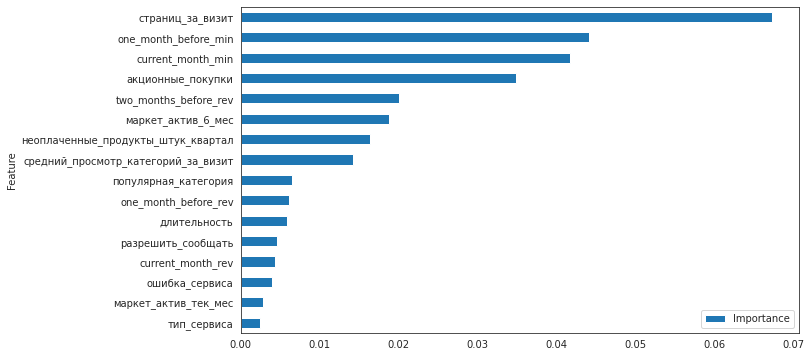

In [123]:
# Вычисляем важность признаков
result = permutation_importance(
    randomized_search.best_estimator_, 
    X_test, 
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Создаем DataFrame
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
}).sort_values('Importance', ascending=True)

# Создаем график
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6));

  0%|          | 0/5 [00:00<?, ?it/s]

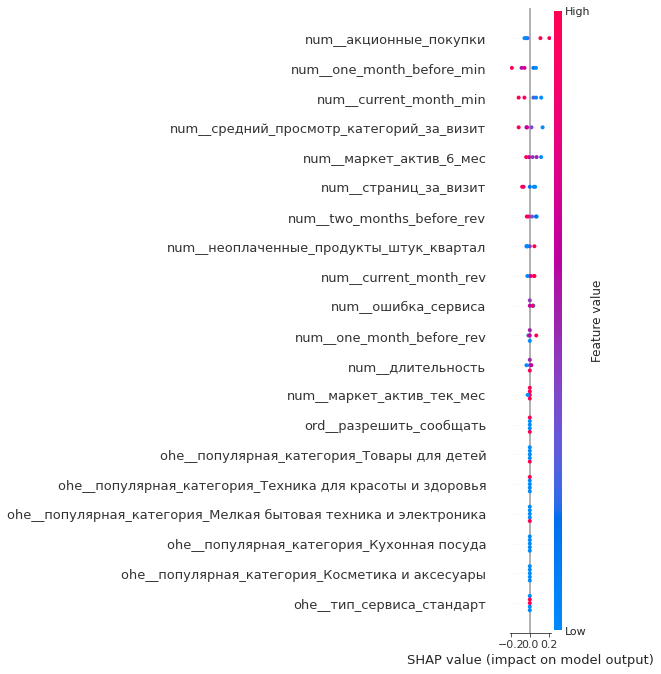

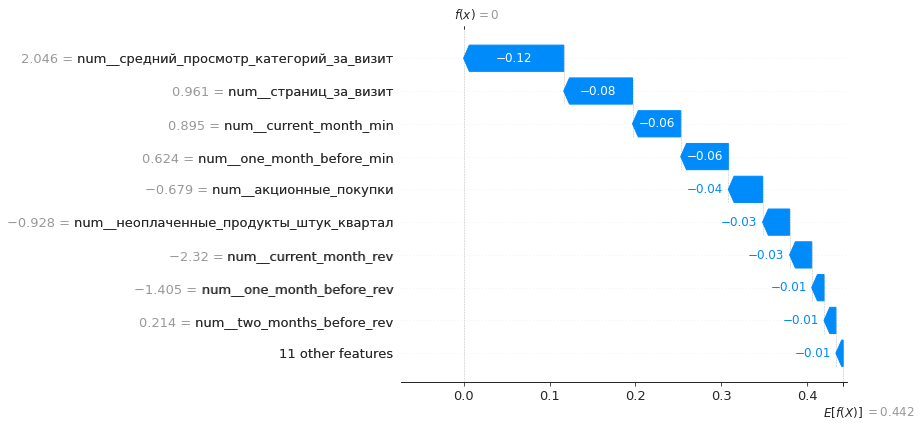

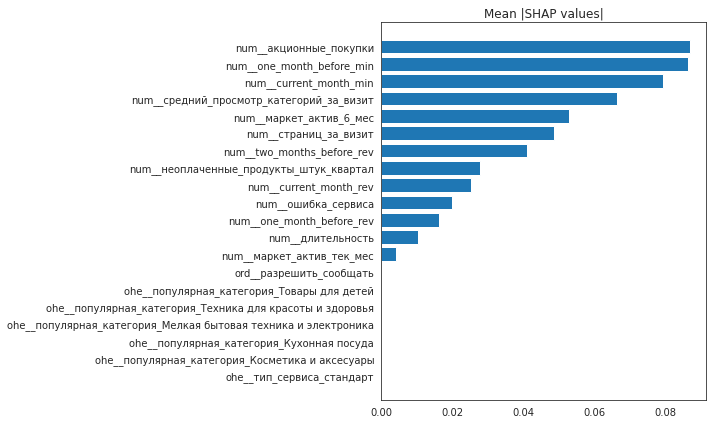

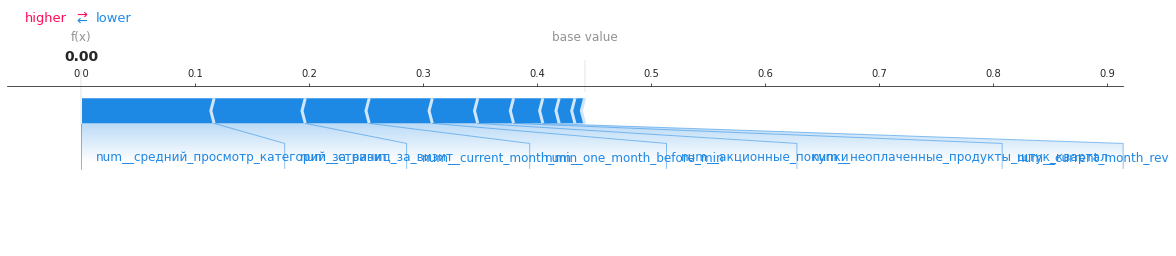

None

In [150]:
# SHAP анализ

# Получаем подготовленные данные
X_train_preprocessed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_train)
X_test_preprocessed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)


# Создаем explainer для класса 1 ("Снизилось")
explainer = shap.KernelExplainer(
    lambda x: trained_model.predict_proba(x)[:,1],  # Вероятности класса 1
    shap.sample(X_train_preprocessed, 5)
)


# Вычисляем SHAP значения
shap_values = explainer.shap_values(X_test_preprocessed[:5])

# Создаем Explanation объект вручную
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_preprocessed[:5],
    feature_names=feature_names
)

#График shap.plots.beeswarm
shap.summary_plot(shap_values, X_test_preprocessed[:5], feature_names=feature_names)


#График shap.plots.waterfall
shap.plots.waterfall(shap_explanation[0])

#График shap.plots.bar
mean_shap = np.abs(shap_values).mean(0)
sorted_idx = np.argsort(mean_shap)[-20:]  # Топ-20 признаков

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), mean_shap[sorted_idx], color='#1f77b4')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.title("Mean |SHAP values|")
plt.tight_layout()
plt.show()

#Force plot
shap.initjs()
display(shap.force_plot(
    explainer.expected_value,
    shap_values[0,:], 
    feature_names=feature_names,
    matplotlib=True  # Используем matplotlib вместо JS для ноутбуков
))

**Выводы**
- Метрика ROC-AUC при кросс-валидации: 0.9795 для модели лидера (DecisionTreeClassifier(max_depth=33, max_features=11) и без масштабирования (passthrough))
- график важности с помощью метода SHAP построен 
- самый значимый признак для модели: страниц_за_визит
- самый НЕзначимый признак для модели: период_выручки,период_времени. Эти признаки можно исключить, они не оказываают влияния на модель

## Шаг 8. Сегментация покупателей

In [ ]:
# Сбрасываем индекс pivot_period, чтобы id стала колонкой
pivot_period_small = pivot_period.reset_index()[['id', 'cum_3_months']]

# Объединяем с исходным DataFrame
data = pd.merge(df, pivot_period_small, on='id', how='left')
data.head()

In [ ]:
#обзор значений
pivot_period['cum_3_months'].describe()

In [ ]:
#расчет групп прибыльности 

q1_cum_3_months = pivot_period['cum_3_months'].quantile(0.25)
q2_cum_3_months = pivot_period['cum_3_months'].quantile(0.5)
q3_cum_3_months = pivot_period['cum_3_months'].quantile(0.75)
q4_cum_3_months = pivot_period['cum_3_months'].quantile(1)
print (q1_cum_3_months, q2_cum_3_months, q3_cum_3_months, q4_cum_3_months) 

In [ ]:
#  группировка по прибыльности покупателей
def categorize_profit(cum_3_months):
    if cum_3_months <= q1_cum_3_months:
        return 25
    if cum_3_months <= q2_cum_3_months and cum_3_months > q1_cum_3_months :
        return 50
    if cum_3_months <= q3_cum_3_months and cum_3_months > q2_cum_3_months :
        return 75    
    else:
        return 100

data['cum_3_months_group'] = data.apply(lambda x: categorize_profit(x['cum_3_months']), axis=1)
data.head()

In [ ]:
# анализ значений данных 
pd.set_option('display.max_rows',None)
pivot_cum_3_months_group=data.pivot_table(index= [ 'cum_3_months_group', 'покупательская_активность']
                                                 , values='id'
                                                , aggfunc='count')
pivot_cum_3_months_group.columns=['count_id']
pivot_cum_3_months_group['ratio']= pivot_cum_3_months_group['count_id']/df['id'].shape[0]
pivot_cum_3_months_group.sort_values(by='ratio', ascending=False)

In [ ]:
# анализ значений данных 
pd.set_option('display.max_rows',None)
pivot_action=data.pivot_table(index= ['акционные_покупки', 'покупательская_активность']
                                                 , values='id'
                                                 , aggfunc='count')
pivot_action.columns=['count_id']
pivot_action['ratio']= pivot_action['count_id']/df['id'].shape[0]
pivot_action.sort_values(by='ratio', ascending=False)

In [ ]:
# анализ значений данных 
pd.set_option('display.max_rows',None)
pivot_pop_cat=data.pivot_table(index= ['популярная_категория', 'покупательская_активность']
                                                 , values='id'
                                                 , aggfunc='count')
pivot_pop_cat.columns=['count_id']
pivot_pop_cat['ratio']= pivot_pop_cat['count_id']/df['id'].shape[0]
pivot_pop_cat.sort_values(by='ratio', ascending=False)

In [ ]:
# анализ значений данных 
pd.set_option('display.max_rows',None)
data_tech = data.query('популярная_категория == "Мелкая бытовая техника и электроника" ')
pivot_pop_cat_id=data_tech.pivot_table(index=  'id' 
                                  , values='популярная_категория'
                                  , aggfunc='count')
pivot_pop_cat_id.columns=['count_pop_cat']
pivot_pop_cat_id.sort_values(by='count_pop_cat', ascending=True)
pivot_pop_cat_id.head()

In [ ]:
# анализ значений данных 
pd.set_option('display.max_rows',None)
pivot_pages_visit =data.pivot_table(index= ['страниц_за_визит', 'покупательская_активность']
                                                 , values='id'
                                                 , aggfunc='count')
pivot_pages_visit.columns =['count_id']
pivot_pages_visit['ratio'] = pivot_pages_visit['count_id']/df['id'].shape[0]
pivot_pages_visit.sort_values(by='ratio', ascending=False)

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query(' 10000<=cum_3_months <= 40000 ')
    , x="страниц_за_визит"
    , y="cum_3_months" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"

);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('10000<=cum_3_months <= 40000 & страниц_за_визит <=5')
    , x="страниц_за_визит"
    , y="cum_3_months" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"

);

**Комментарий**

Убрав выброс cum_3_months в районе 120 000 видня явная связь, что менее 3 страниц за визит явный сигнал , что покупательская активность снизилась 

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data,  x="минут", y="cum_3_months" ,  hue="покупательская_активность", style="покупательская_активность"
);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
     data=data.query('минут <=12.5'),  x="минут", y="cum_3_months" ,  hue="покупательская_активность", style="покупательская_активность"
);

**Комментарий**

видна явная связь, что менее 11 минут явный сигнал , что покупательская активность снизилась 

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('cum_3_months >= 10000')
    , x="популярная_категория"
    , y="cum_3_months" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('cum_3_months >= 10000 & популярная_категория == "Мелкая бытовая техника и электроника"')
    , x="популярная_категория"
    , y="cum_3_months" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('популярная_категория == "Мелкая бытовая техника и электроника"')
    , x="популярная_категория"
    , y="минут" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('cum_3_months >= 10000 & популярная_категория == "Товары для детей"')
    , x="популярная_категория"
    , y="cum_3_months" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('популярная_категория == "Товары для детей"')
    , x="популярная_категория"
    , y="минут" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('акционные_покупки <= 0.4 & cum_3_months >= 10000')
    , x="акционные_покупки"
    , y="cum_3_months" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('cum_3_months >= 10000')
    , x="маркет_актив_6_мес"
    , y="cum_3_months" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('cum_3_months >= 10000')
    , x="длительность"
    , y="cum_3_months" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

**Комментарий**

видна явная связь, что при росте акционных покупок (>0.2) и любом cum_3_months высока явроятность сниженной покупательской активности
если среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев менее 4 высока явроятность сниженной покупательской активности
любая длительность не  признак снижения активности

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('акционные_покупки <= 0.4')
    , x="акционные_покупки"
    , y="минут" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('акционные_покупки <= 0.4')
    , x="маркет_актив_6_мес"
    , y="минут" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('акционные_покупки <= 0.4')
    , x="маркет_актив_6_мес"
    , y="минут" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

In [ ]:
# диаграммы рассеяния 
sns.scatterplot(
    data=data.query('акционные_покупки <= 0.4')
    , x="длительность"
    , y="минут" 
    ,  hue="покупательская_активность"
    , style="покупательская_активность"
);

сколько дней прошло с момента регистрации покупателя на сайте.

**Комментарий**

видна явная связь, что при росте акционных покупок (>0.2) и низком кол-ве минут (<10) высока явроятность сниженной покупательской активности
если среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев менее 4 высока явроятность сниженной покупательской активности
кол-во дней  с момента регистрации покупателя на сайте не  признак снижения активности

In [ ]:
## прогноз Y на базе обученной модели и датасета

# 1. подготовка данных аналогично тренировочной выборке
# Выделение нужных признаков из датасета data
X_dt = data[['тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'период_выручки', 'выручка', 'период_времени',
       'минут']]

# 2. преобразование категориальных признаков с помощью обученного OneHotEncoder
X_dt_ohe = ohe.transform(X_dt[cols_ohe])  # Используем обученный encoder
#X_dt_ohe = pd.DataFrame(X_dt_ohe, columns=cols_ohe)

# 3. преобразование категориальных признаков с помощью обученного OrdinalEncoder
X_dt_ord = ord_enc.transform(X_dt[cols_ord])# Используем обученный encoder
X_dt_ord = pd.DataFrame(X_dt_ord, columns=cols_ord)

# 4.   количественные признаки 
X_dt_num = X_dt[num_columns].values
X_dt_num = pd.DataFrame(X_dt_num, columns=num_columns)


# 5. объединение преобразованных данных
#X_dt_processed = pd.concat([X_dt_ohe, X_dt_ord, X_dt_num], axis=1)
X_dt_processed = np.hstack([X_dt_ohe, X_dt_ord, X_dt_num])

# 6. получение прогнозов
dt_predictions = dt.predict(X_dt_processed)

# 7. добавление прогнозов в датасет
data['y_dt_predictions'] = dt_predictions

# 8. просмотр результатов
data.head()

In [ ]:
# анализ значений данных 
pd.set_option('display.max_rows',None)
pivot_fact_pred =data.pivot_table(index= ['act_type', 'y_dt_predictions']
                                                 , values='id'
                                                 , aggfunc='count')
pivot_fact_pred.columns =['count_id']
pivot_fact_pred['ratio']= pivot_fact_pred['count_id']/data['id'].shape[0]
pivot_fact_pred

**Комментарий**

- модель ошиблась в 0.3% случаях: 
- предсказала как "Снижение активности" в 2 случаях из 2286 (0.000875)
- предсказала как "Текущий уровень активности" в 5 случаях из 2286 (0.002187)


**Выводы**

- добавлена колонка в data c сегментацией клиентов в зависмости от их прибыльности (выше или ниже медианного значения за последние 3 месяца)
- создан датафрейм data_low_pr с прогнозом покупательской активности для группы с низкой прибыльностью

Зависимости и выводы:
- убрав выброс cum_3_months в районе 120 000 видня явная связь, что менее 3 страниц за визит явный сигнал , что покупательская активность снизилась, при этом популярная категория не влияет на этот вывод.
- видна явная связь, что менее 11 минут явный сигнал , что покупательская активность снизилась, при этом популярная категория не влияет на этот вывод.
- видна явная связь, что при росте акционных покупок (>0.2) и низком кол-ве минут (<10) высока явроятность сниженной покупательской активности
- видна явная связь, что при росте акционных покупок (>0.2) и любом cum_3_months высока явроятность сниженной покупательской активности
- если среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев менее 4 высока явроятность сниженной покупательской активности
- кол-во дней  с момента регистрации покупателя на сайте не  признак снижения активности

Флаги:
- Нужно внедрить флаги в  таблицы данных и начать проводить спец. акции для клиентов, попавших в группу риска:
    - менее 11 минут  проведённого на сайте ( в т.ч. в категории мелкая бытовая техника и товары для детей),
    - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев > 0.2
    - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев менее 4
    
Точность модели на всех данных:
- модель ошиблась в 0.3% случаях: 
- предсказала как "Снижение активности" в 2 случаях из 2286 (0.000875)
- предсказала как "Текущий уровень активности" в 5 случаях из 2286 (0.002187)


## Шаг 9. Общий вывод

**Загрузка данных**

- 4 таблицы market_file, market_money, market_time, money были пролиты
- изменение названий столбцов произведено во всех таблицах на змеинный регистр и пропислные буквы, оставлена кириллица 
- объединение таблиц будет произведено на шаге 4. Объединение таблиц

**Предобработка данных**
- Данные были предобработаны:
    - названия в данных исправлены:
    - колонка период в market_time имела орфографические ошибки
    - колонка тип сервиса в market_file имела орфографические ошибки
    - типы даных заменены:
        - колонки id: типы данных заменены c тип "int" на тип "object"
        - колонка прибыль:типы данных заменены c тип "object" на тип "float"
    - нет пропущенных значений для каждого столбца в каждой таблице
    - нет строк-дубликатов в данных в каждой таблице

**Исследовательский анализ данных**

- Все клиенты (1300) имеют покупательскую активностью не менее трёх месяцев, то есть все покупали минимум 1 товар за последние 3 месяца, при этом:
    - Количество клиентов c нулевыми доходами за 3 месяца кумулятивно в market_money: 0
    - Количество клиентов c нулевыми доходами за текущий месяц в market_money: 0
    - Количество клиентов c нулевыми доходами за прошлый месяц в market_money: 3
    - Количество клиентов c нулевыми доходами за позапрошлый месяц в market_money: 3
    - Три клиента c нулевыми доходами за прошлый И позапрошлый месяц - одни и теже люди c id 215348, 215357, 215359
- Три клиента принесли менее 1 у.е.среднемесячной прибыли за последние 3 месяца: 216122, 216324, 215348
- Суммарное падение времени, проведённого на сайте, по всем клиентам в market_time при одинаковом кол-ве клиентов (1300) в прошлый и текущий месяца:
    - Количество клиентов c нулевым ростом времени, проведённого на сайте в market_time: 116
    - Количество клиентов c положительным ростом времени, проведённого на сайте в market_time: 584
    - Количество клиентов c отрицательным ростом времени, проведённого на сайте в market_time: 600
- Cамая популярная категория - Товары для детей - стандарт. Для большего кол-ва клиентов она и снизилась.
- Покупательская_активность делаю как значения 1 (снизилась) и 0 (прежняя) для лучшей интерпретируемости в будущем

**Объединение таблиц**

- Объединены таблицы market_file.csv, market_money.csv, market_time.csv в df
- В df есть 2 поля "период_выручки" из market_money и "период времени" из market_time

**Корреляционный анализ**

- Теснота связи слабая или ниже между количесвенными параметрами (корреляция по Пирсону):
    - Слабая "-" теснота связи акционные_покупки и страниц_за_визит 
    - Слабая "+" теснота связи минут и страниц_за_визит
- Самые высокие корреляции между категориальными и количесвенными признаками (коэффициент корреляции Фи):
    - покупательская_активность - маркет_актив_6_мес    0.6
    - покупательская_активность - страниц_за_визит    0.8
    - покупательская_активность- минут    0.6
- О мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю. В такой ситуации лишние коррелирующие признаки нужно удалять из обучающей выборки.Среди количесвенных признаков таких нет => т.о, надо убрать поле ID из анализа.

**Использование пайплайнов**

- Во время подготовки данных использован ColumnTransformer. Количественные и категориальные признаки обработаны в пайплайне раздельно. Для кодирования категориальных признаков использованы два кодировщика OneHotEncoder() и OrdinalEncoder(), для масштабирования количественных — два скейлера StandardScaler(), MinMaxScaler().
- Обучены четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Для каждой из них подобраны гиперпараметры. Метрика ROC-AUC с настройкой ovo на тестовой выборке использована для оценки моделей, так как она подходит к ситуациям, когда примеров одного класса больше, чем другого.
- Для выбора лучшей модель, использован один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который ищет лучшую модель.Использована RandomisedSearchCV.
- Лучше всего справилась модель DecisionTreeClassifier(max_depth=33, max_features=11) и без масштабирования (passthrough).
    - Метрика лучшей модели на тренировочной выборке: 0.979499923300087
    - Метрика ROC-AUC (ovo) на тестовой выборке: 0.9888965671497294

**Анализ важности признаков**

- Метрика ROC-AUC при кросс-валидации: 0.9795 для модели лидера (DecisionTreeClassifier(max_depth=33, max_features=11) и без масштабирования (passthrough))
- график важности с помощью метода SHAP построен
- самый значимый признак для модели: страниц_за_визит
- в топ-5 по значимости попали: страниц_за_визит,  минут, маркет_актив_6_мес, акционные_покупки
- самый НЕзначимый признак для модели: период_выручки,период_времени. Эти признаки можно исключить, они не оказываают влияния на модель

**Сегментация покупателей**

- добавлена колонка в data c сегментацией клиентов в зависмости от их прибыльности (выше или ниже медианного значения за последние 3 месяца)
- создан датафрейм data_low_pr с прогнозом покупательской активности для группы с низкой прибыльностью

Зависимости и выводы:
- убрав выброс cum_3_months в районе 120 000 видня явная связь, что менее 3 страниц за визит явный сигнал , что покупательская активность снизилась, при этом популярная категория не влияет на этот вывод.
- видна явная связь, что менее 11 минут явный сигнал , что покупательская активность снизилась, при этом популярная категория не влияет на этот вывод.
- видна явная связь, что при росте акционных покупок (>0.2) и низком кол-ве минут (<10) высока явроятность сниженной покупательской активности
- видна явная связь, что при росте акционных покупок (>0.2) и любом cum_3_months высока явроятность сниженной покупательской активности
- если среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев менее 4 высока явроятность сниженной покупательской активности
- кол-во дней с момента регистрации покупателя на сайте не признак снижения активности

Флаги:
- Нужно внедрить флаги в таблицы данных и начать проводить спец. акции для клиентов, попавших в группу риска:
    - менее 11 минут проведённого на сайте ( в т.ч. в категории мелкая бытовая техника и товары для детей),
    - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев > 0.2
    - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев менее 

Точность модели на всех данных:
- модель ошиблась в 0.3% случаях:
    - предсказала как "Снижение активности" в 2 случаях из 2286 (0.000875)
    - предсказала как "Текущий уровень активности" в 5 случаях из 2286 (0.002187)

**Рекомендация для заказчика**

- Заказчику внеобходимо начать контролировать маркеры/флаги, которые свидетельсвуют о снижении актвиности такие как: 
    - менее 11 минут  проведённого на сайте ( в т.ч. в категории мелкая бытовая техника и товары для детей),
     - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев > 0.2
     - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев менее 4
- Заказчику необходимо начать делать индивидуальные спец акции, когда маркеры свидетельсвуют о снижении актавности
